# E-Commerce Customer Churn Prediction

In [518]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import numpy as np
import xgboost
import catboost
from scipy.stats import shapiro, kstest, pointbiserialr, mannwhitneyu
from pycaret.classification import *
from typing import Literal
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
from sklearn.metrics import classification_report, average_precision_score
from sklearn.base import BaseEstimator, TransformerMixin, clone
from pycaret.internal.preprocess.transformers import TransformerWrapper, FixImbalancer
from imblearn.over_sampling import *
from imblearn.under_sampling import *

df = pd.read_csv('data_ecommerce_customer_churn.csv')
pd.set_option('display.float_format', '{:,.4f}'.format)

## Business Understanding

* The e-commerce sector has experienced remarkable growth in the past few years, marked by a surge in the number of enterprises venturing into the online marketplace. 
* Grasping the intricacies of customer behavior plays a pivotal role in the prosperity of e-commerce ventures. An essential metric in this regard is customer churn, denoting the pace at which customers discontinue their transactions with an online retailer.

### Significance

* Recognizing and forecasting customer churn offers e-commerce enterprises a strategic edge, enabling them to address issues in advance and retain valuable clientele. 
* Churn significantly influences revenue, with retaining current customers usually being a more budget-friendly approach than acquiring new ones. Prediction models aid in the efficient allocation of resources.

### Goals
This project aims to create a predictive model utilizing Machine Learning algorithms for analyzing customer attrition in the E-commerce sector.

Objectives:
* Identify the primary factors influencing customer attrition in E-commerce.
* Determine the most effective algorithm for precise prediction of customer churn through comprehensive performance metric evaluation.
* Propose customer retention strategies derived from insights obtained during the analysis such as giving $100 vouchers to customers predicted as churn (Average Customer Lifetime Value for ecommerce brands is $168 according to [this article](https://www.bigcommerce.com/ecommerce-answers/what-is-customer-lifetime-value-and-why-is-it-very-important/))

# Data Understanding

### Attributes

| **Features** | **Description** |
| --- | --- |
| **Tenure** | Tenure of a customer in the company. |
| **WarehouseToHome** | Distance between the warehouse to the customer’s home. |
| **NumberOfDeviceRegistered** | Total number of deceives is registered on a particular customer. |
| **PreferedOrderCat** | Preferred order category of a customer in the last month. |
| **SatisfactionScore** | Satisfactory score of a customer on service. |
| **MaritalStatus** | Marital status of a customer. |
| **NumberOfAddress** | Total number of added on a particular customer. |
| **Complaint** | Any complaint has been raised in the last month. |
| **DaySinceLastOrder** | Day since last order by customer. |
| **CashbackAmount** | Average cashback in last month. |
---

| **Target** | Description |
| --- | --- |
| **Churn** | Churn flag. |

In [519]:
display(df.describe(), df.describe(include=object))

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,"3,747.0000","3,772.0000","3,941.0000","3,941.0000","3,941.0000","3,941.0000","3,728.0000","3,941.0000","3,941.0000"
mean,10.0814,15.6506,3.6793,3.0883,4.2378,0.2824,4.5317,176.7074,0.1710
std,8.4989,8.4523,1.0139,1.3818,2.6267,0.4502,3.6676,48.7918,0.3766
min,0.0000,5.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000
25%,2.0000,9.0000,3.0000,2.0000,2.0000,0.0000,2.0000,145.7000,0.0000
50%,9.0000,14.0000,4.0000,3.0000,3.0000,0.0000,3.0000,163.3400,0.0000
75%,16.0000,21.0000,4.0000,4.0000,6.0000,1.0000,7.0000,195.2500,0.0000
max,61.0000,127.0000,6.0000,5.0000,22.0000,1.0000,46.0000,324.9900,1.0000


,PreferedOrderCat,MaritalStatus
count,3941,3941
unique,6,3
top,Laptop & Accessory,Married
freq,1458,2055


* We can observe outliers in some attributes.
* The minimum value of `Tenure` is 0. However, as we do not know the unit of `Tenure` (day, month, etc), we won't replace the value.
* From the mean of the attribute target attribute `Churn` of 0.171, we can identify a significant imbalance in the target.

In [520]:
print(f'The number of rows and columns in the dataset are {df.shape}')
df.info()

The number of rows and columns in the dataset are (3941, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


## Identify Problems

In [521]:
df.duplicated().sum()
df = df.drop_duplicates()

We found 671 duplicate observations, which has to be handled by keeping only the first observation.

In [522]:
df.isnull().sum()

Tenure                      160
WarehouseToHome             135
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           181
CashbackAmount                0
Churn                         0
dtype: int64

* here are a few missing values which has to be imputed during preprocessing.
* The imputation method depends on whether the missing values are MCAR or MAR.

In [523]:
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,Tenure,36,"[15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0,..."
1,WarehouseToHome,33,"[29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0..."
2,NumberOfDeviceRegistered,6,"[4, 3, 6, 2, 5, 1]"
3,PreferedOrderCat,6,"[Laptop & Accessory, Mobile, Fashion, Others, ..."
4,SatisfactionScore,5,"[3, 1, 4, 2, 5]"
5,MaritalStatus,3,"[Single, Married, Divorced]"
6,NumberOfAddress,14,"[2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21]"
7,Complain,2,"[0, 1]"
8,DaySinceLastOrder,22,"[7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0,..."
9,CashbackAmount,2335,"[143.32, 129.29, 168.54, 230.27, 322.17, 152.8..."


In [524]:
marital_status_counts = df['MaritalStatus'].value_counts(normalize=True) * 100

print("Percentages of each unique value in MaritalStatus:")
print(marital_status_counts)

Percentages of each unique value in MaritalStatus:
Married    51.5596
Single     30.8257
Divorced   17.6147
Name: MaritalStatus, dtype: float64


No rare category in `MaritalStatus`

In [525]:
pref_order_counts = df['PreferedOrderCat'].value_counts(normalize=True) * 100

print("Percentages of each unique value in PreferedOrderCat:")
print(pref_order_counts)

Percentages of each unique value in PreferedOrderCat:
Laptop & Accessory   37.0948
Mobile Phone         22.1713
Fashion              14.8012
Mobile               14.0061
Grocery               7.3700
Others                4.5566
Name: PreferedOrderCat, dtype: float64


* The category 'Others' constitutes only 4.5% of the attribute.
* For now, we will leave it as is and address it if necessary after evaluating model performance.

<function matplotlib.pyplot.show(close=None, block=None)>

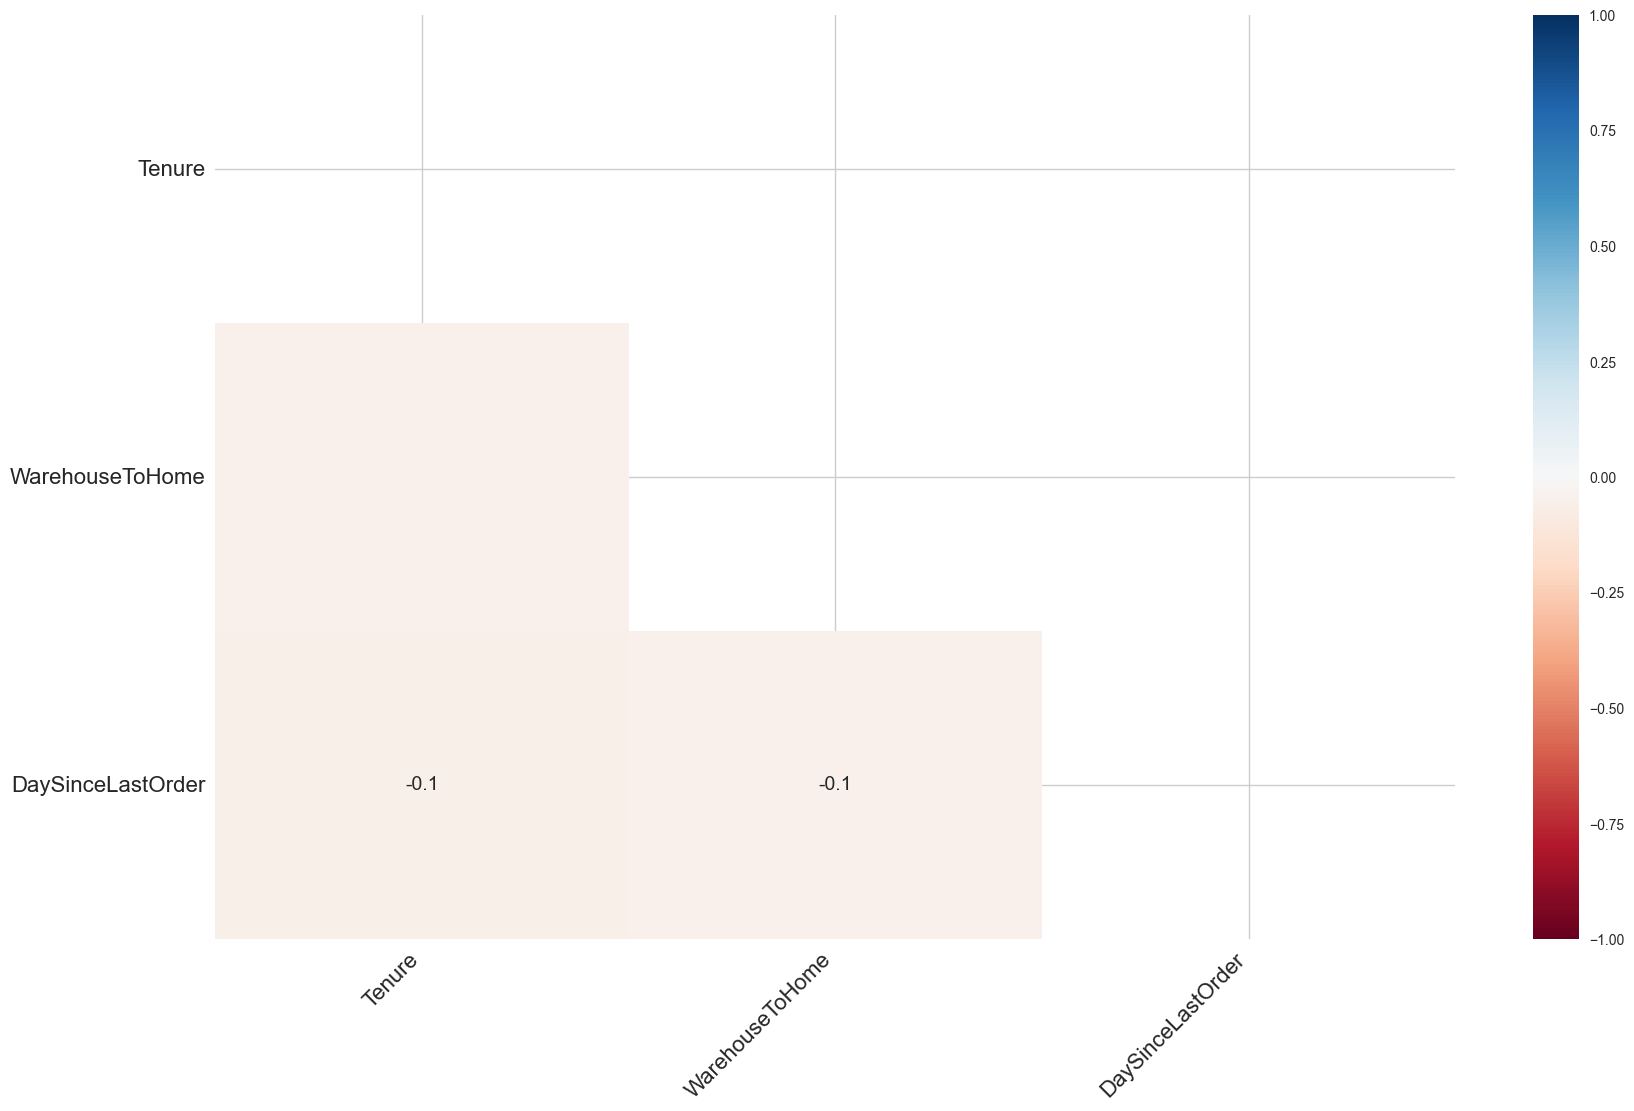

In [526]:
msno.heatmap(df)
plt.show

* Low correlation values show lack of dependence between occurrence of missing values.
* We can assume that missing values are MCAR.
* We will be using single imputation method.

# Exploratory Data Analysis

## Data Distribution

<Figure size 1800x900 with 0 Axes>

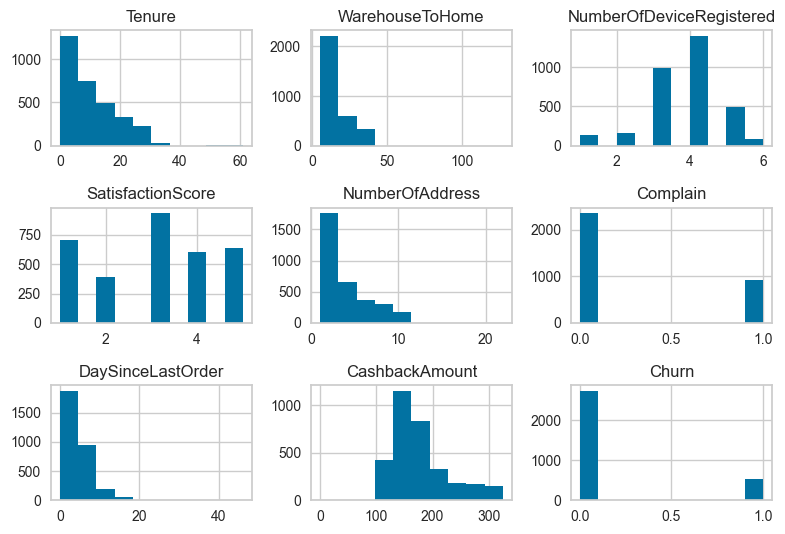

In [527]:
numeric_columns = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(18, 9))
df.hist()
plt.tight_layout()
plt.show()

* Based on the histogram, most, if not all of the attributes seem to be either skewed or imbalanced (in the case of `complain` and `churn`).

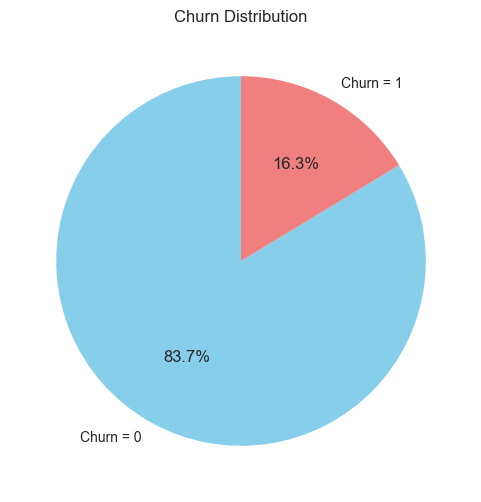

In [528]:
churn_dist = df['Churn'].value_counts()

labels = ['Churn = 0', 'Churn = 1']

plt.figure(figsize=(6, 6))
plt.pie(churn_dist, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Churn Distribution')
plt.show()

From the pie chart, we can observe that the target attribute `Churn` is significantly imbalanced, where majority is Churn = 0 at 83.7%, while Churn = 1 is only at 16.3%.

# Normal Test

In [529]:
numeric_columns = df.select_dtypes(include=['number']).columns
results_table = []

def normality_test(data_column):
    
    # Drop missing values before testing
    data_column = data_column.dropna()
    shapiro_stat, shapiro_p_value = shapiro(data_column)
    ks_stat, ks_p_value = kstest(data_column, 'norm')
    return shapiro_stat, shapiro_p_value, ks_stat, ks_p_value

for column in numeric_columns:
    shapiro_stat, shapiro_p_value, ks_stat, ks_p_value = normality_test(df[column])
    
    results_table.append([
        column,
        shapiro_stat, shapiro_p_value,
        ks_stat, ks_p_value,
    ])

headers = ['Variable', 'Shapiro-Wilk Statistic', 'Shapiro-Wilk p-value', 'KS Statistic', 'KS p-value']
display((pd.DataFrame(results_table, columns=headers)))

,Variable,Shapiro-Wilk Statistic,Shapiro-Wilk p-value,KS Statistic,KS p-value
0,Tenure,0.9161,0.0000,0.7580,0.0000
1,WarehouseToHome,0.8599,0.0000,1.0000,0.0000
2,NumberOfDeviceRegistered,0.8953,0.0000,0.9354,0.0000
3,SatisfactionScore,0.8864,0.0000,0.8413,0.0000
4,NumberOfAddress,0.8744,0.0000,0.9084,0.0000
5,Complain,0.5632,0.0000,0.5000,0.0000
6,DaySinceLastOrder,0.8876,0.0000,0.7694,0.0000
7,CashbackAmount,0.8897,0.0000,0.9991,0.0000
8,Churn,0.4449,0.0000,0.5000,0.0000


* Both Shapiro-Wilk and Kolmogorov-Smirnov normality test indicates that none of the attributes are normally distributed.
* To impute missing values, median imputation will be more suitable than mean imputation.
* For certain models to work properly, outliers will have to be handled.

## Analysis of Categorical Attributes

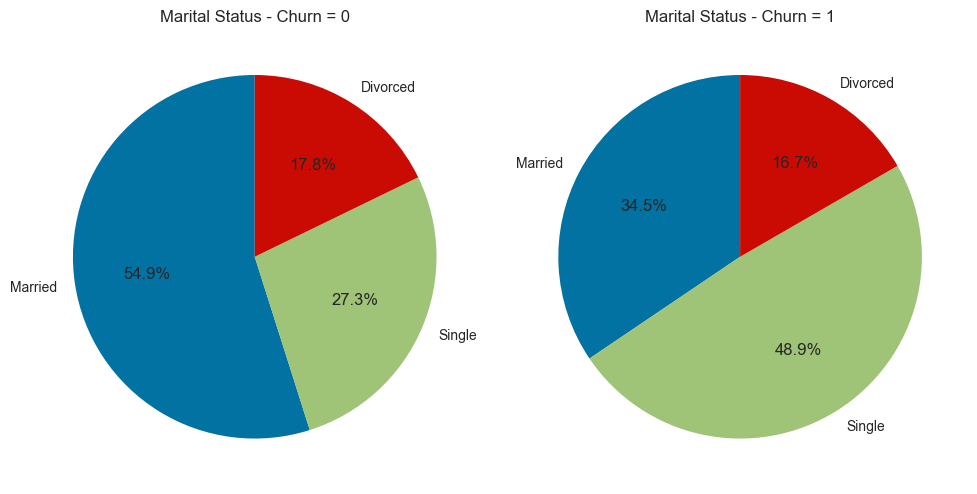

In [530]:
category_order = ['Married', 'Single', 'Divorced']

churn_0_data = df[df['Churn'] == 0]

marital_status_churn_0 = churn_0_data['MaritalStatus'].value_counts(normalize=True).reindex(category_order) * 100

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(marital_status_churn_0, labels=marital_status_churn_0.index, autopct='%1.1f%%', startangle=90)
plt.title('Marital Status - Churn = 0')

churn_1_data = df[df['Churn'] == 1]

marital_status_churn_1 = churn_1_data['MaritalStatus'].value_counts(normalize=True).reindex(category_order) * 100

plt.subplot(1, 2, 2)
plt.pie(marital_status_churn_1, labels=marital_status_churn_1.index, autopct='%1.1f%%', startangle=90)
plt.title('Marital Status - Churn = 1')

plt.tight_layout()
plt.show()


From the pie charts, we can observe the following:

* The category 'Divorced' has similar proportions in both charts.
* The proportion of 'Married' is larger for customers with churn = 0.
* The proportion of 'Single' is larger for customers with churn = 1.

This suggests that single customers are more likely to churn than married customers.

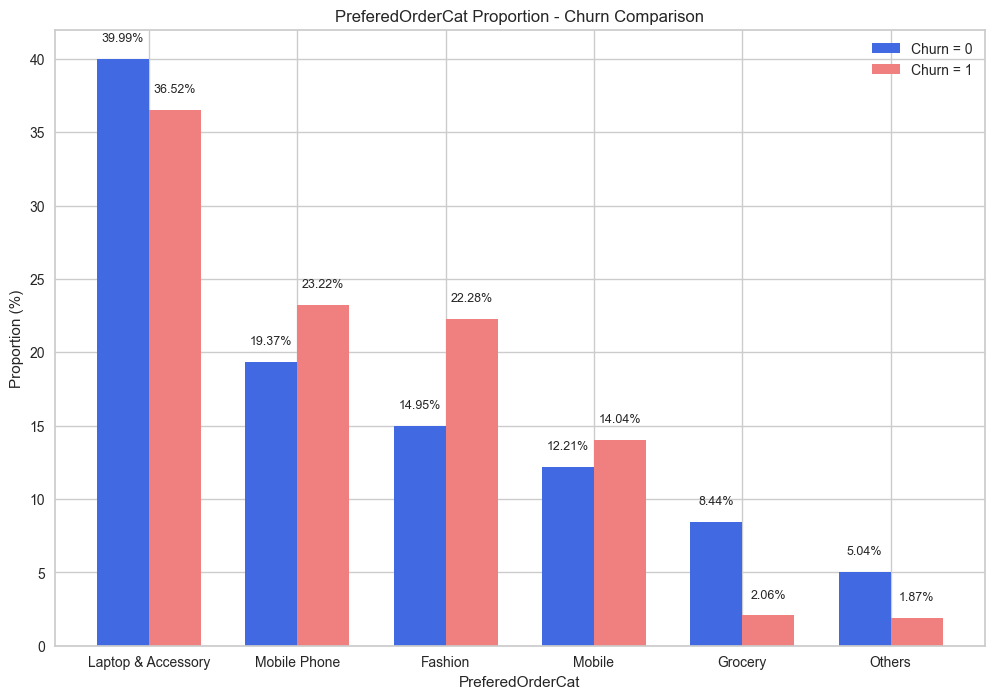

In [531]:
import matplotlib.pyplot as plt
import pandas as pd

churn_0_data = df[df['Churn'] == 0]

prefered_order_churn_0 = churn_0_data['PreferedOrderCat'].value_counts(normalize=True) * 100

churn_1_data = df[df['Churn'] == 1]

prefered_order_churn_1 = churn_1_data['PreferedOrderCat'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35
r1 = range(len(prefered_order_churn_0))

for i in r1:
    ax.bar(i - bar_width/2, prefered_order_churn_0[i], bar_width, label='Churn = 0', color='royalblue')
    ax.bar(i + bar_width/2, prefered_order_churn_1[i], bar_width, label='Churn = 1', color='lightcoral')

    ax.text(i - bar_width/2, prefered_order_churn_0[i] + 1, f"{prefered_order_churn_0[i]:.2f}%", ha='center', va='bottom', fontsize=9)
    ax.text(i + bar_width/2, prefered_order_churn_1[i] + 1, f"{prefered_order_churn_1[i]:.2f}%", ha='center', va='bottom', fontsize=9)

plt.title('PreferedOrderCat Proportion - Churn Comparison')
plt.xlabel('PreferedOrderCat')
plt.ylabel('Proportion (%)')
plt.xticks(r1, prefered_order_churn_0.index)
ax.legend(['Churn = 0', 'Churn = 1'])

plt.show()

From the bar chart, we can observe the following:
* The proportions of the categories 'Laptop & Accessory', 'Grocery', and 'Others' are higher for customers with Churn = 0.
* The proportions of the categories 'Mobile Phone', 'Fashion', and 'Mobile' are higher for customers with Churn = 1.

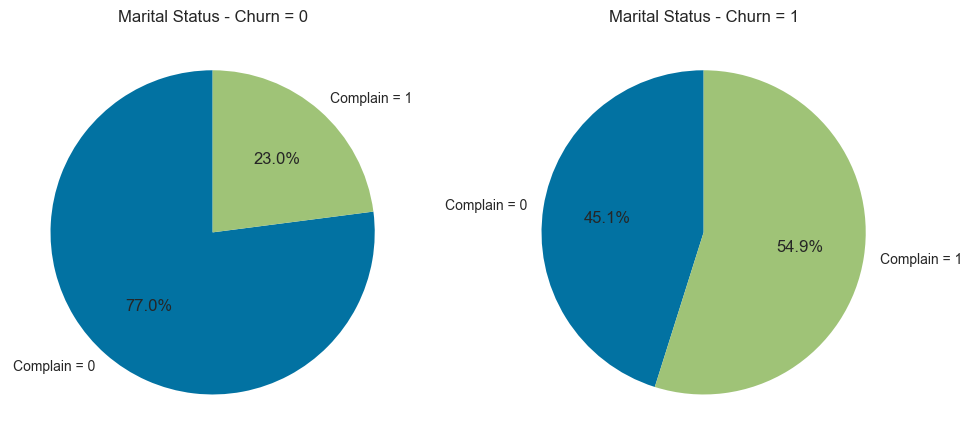

In [532]:
category_order = [0, 1]

complain_churn_0 = churn_0_data['Complain'].value_counts(normalize=True).reindex(category_order) * 100

labels = ['Complain = 0', 'Complain = 1']
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(complain_churn_0, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Marital Status - Churn = 0')

complain_churn_1 = churn_1_data['Complain'].value_counts(normalize=True).reindex(category_order) * 100

plt.subplot(1, 2, 2)
plt.pie(complain_churn_1, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Marital Status - Churn = 1')

plt.tight_layout()
plt.show()

From the pie charts, we can observe the following:
* In the pie chart where churn = 0, the proportion of customers without complaints is significantly higher (77.0%) than customers with complaints.
* In the pie chart where churn = 1, the proportion of customers with complaints is higher (54.9%) than customers without complaints.

This suggests that customers without complaints are less likely to churn than customers with complaints, and vice versa.

## Analysis of Numerical Attributes

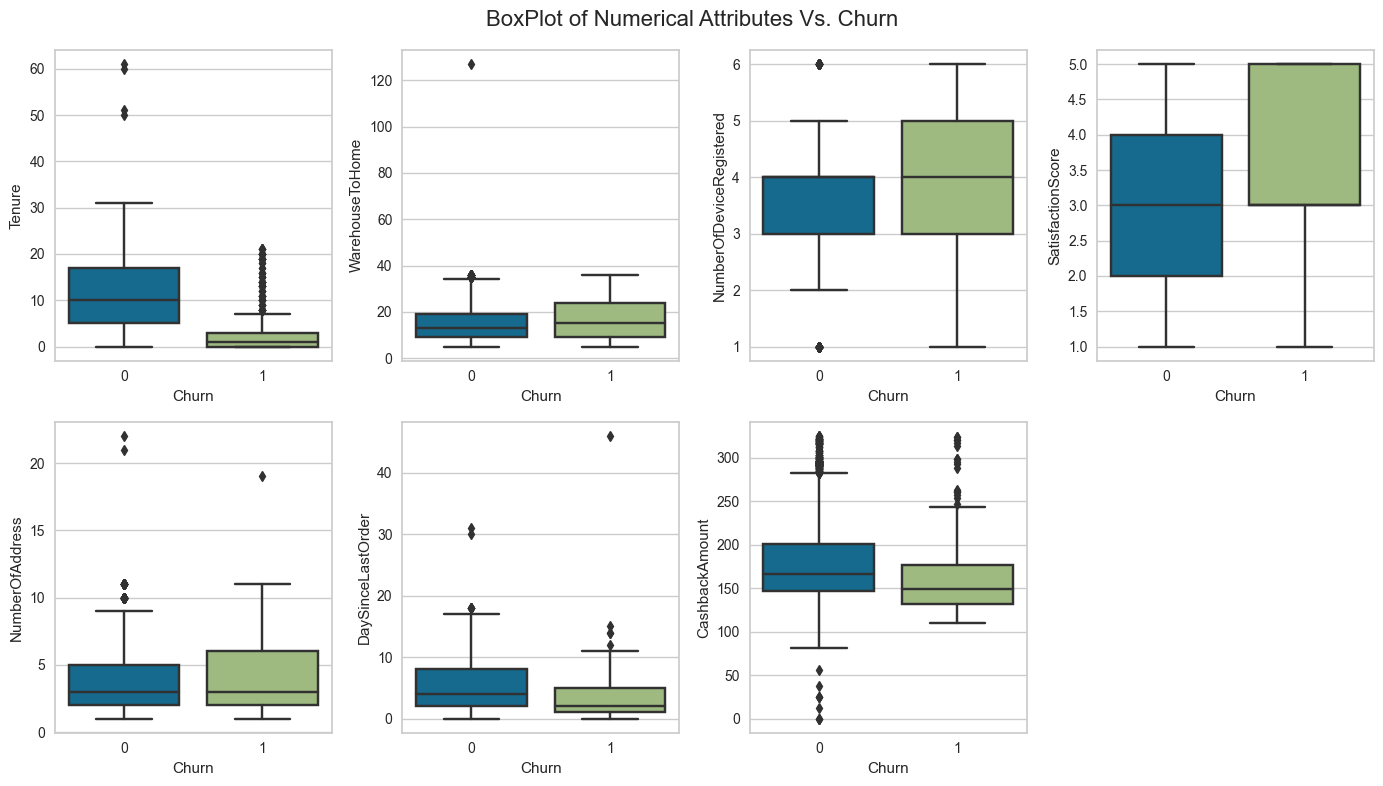

,Variable,Median (Churn=0),Median (Churn=1)
0,Tenure,10.0000,1.0000
1,WarehouseToHome,13.0000,15.0000
2,NumberOfDeviceRegistered,4.0000,4.0000
3,SatisfactionScore,3.0000,3.0000
4,NumberOfAddress,3.0000,3.0000
5,DaySinceLastOrder,4.0000,3.0000
6,CashbackAmount,166.9700,152.8500


In [533]:
fig, axs = plt.subplots(2, 4, figsize=(14, 8))

sns.boxplot(data=df, x='Churn', y='Tenure', ax=axs[0, 0])
sns.boxplot(data=df, x='Churn', y='WarehouseToHome', ax=axs[0, 1])
sns.boxplot(data=df, x='Churn', y='NumberOfDeviceRegistered', ax=axs[0, 2])
sns.boxplot(data=df, x='Churn', y='SatisfactionScore', ax=axs[0, 3])
sns.boxplot(data=df, x='Churn', y='NumberOfAddress', ax=axs[1, 0])
sns.boxplot(data=df, x='Churn', y='DaySinceLastOrder', ax=axs[1, 1])
sns.boxplot(data=df, x='Churn', y='CashbackAmount', ax=axs[1, 2])

axs[1, 3].axis('off')

plt.suptitle('BoxPlot of Numerical Attributes Vs. Churn', fontsize=16)
plt.tight_layout()
plt.show()

numeric_columns = df.select_dtypes(include='number').drop(columns=['Complain', 'Churn']).columns
drop_missing = df.dropna()
churn_data = drop_missing[drop_missing['Churn'] == 1]
no_churn_data = drop_missing[drop_missing['Churn'] == 0]

medians_table = []

for column in numeric_columns:
    median_churn = churn_data[column].median()
    median_no_churn = no_churn_data[column].median()

    medians_table.append({
        'Variable': column,
        'Median (Churn=0)': median_no_churn,
        'Median (Churn=1)': median_churn,
    })

medians_df = pd.DataFrame(medians_table)
display(medians_df)

From the box-plots and table, we can observe the following:
* Customers with higher tenure are **less likely** to churn.
* Customers with higher distance between the warehouse and their home are **more likely** to churn.
* Customers with higher number of days since their last order are **less likely** to churn.
* Customers with higher average cashback amount (in the last month) are **less likely** to churn.
* `NumberOfDeviceRegistered`, `SatisfactionScore`, and `NumberOfAddress` do not seem to significantly affect `Churn`, judging by their medians.

## Correlation Analysis

### Numerical Non-binary Attributes

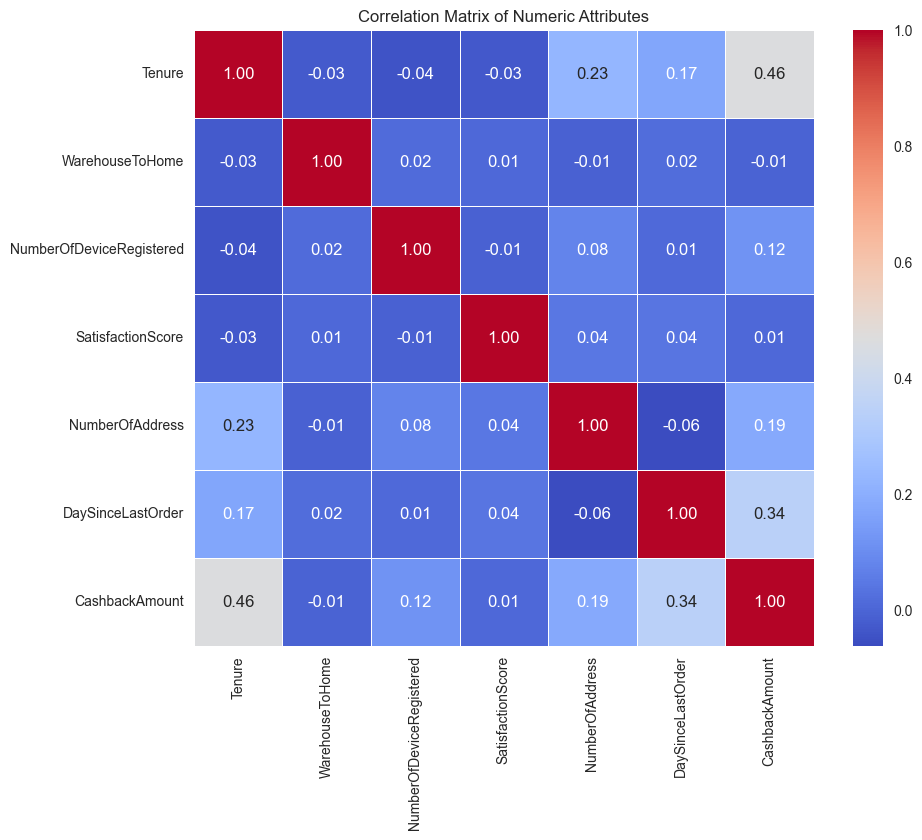

In [534]:
numeric_var = df.select_dtypes(include=['number']).drop(columns=['Complain', 'Churn'])
correlation_matrix = numeric_var.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numeric Attributes')
plt.show()

From the correlation matrix, we can observe the following:
* There is a moderate positive correlation between `Tenure` and `CashbackAmount`, as well as between `DaySinceLastOrder` and `CashbackAmount`.
* Other attributes only exhibit low to no correlation.

### Binary Attributes

interval columns not set, guessing: ['MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'PreferedOrderCat_Fashion', 'PreferedOrderCat_Grocery', 'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile', 'PreferedOrderCat_Mobile Phone', 'PreferedOrderCat_Others', 'Complain', 'Churn']


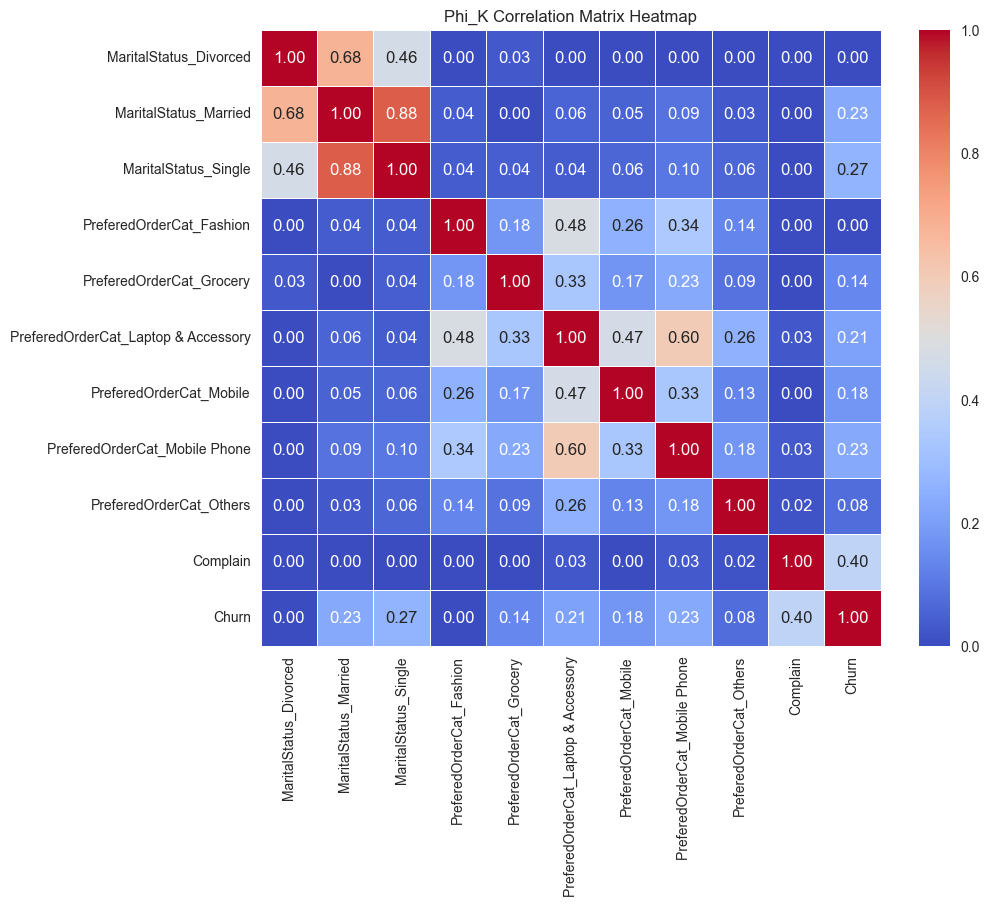

In [535]:
marital_status_dummies = pd.get_dummies(df['MaritalStatus'], prefix='MaritalStatus')
prefered_order_cat_dummies = pd.get_dummies(df['PreferedOrderCat'], prefix='PreferedOrderCat')

dummy_var = pd.concat([marital_status_dummies, prefered_order_cat_dummies, df[['Complain', 'Churn']]], axis=1)

phi_k_matrix = dummy_var.phik_matrix()

plt.figure(figsize=(10, 8))
sns.heatmap(phi_k_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Phi_K Correlation Matrix Heatmap')
plt.show()


We will only look at the correlation between each binary variable and the target attribute `Churn`.

* The attributes `Complain` and `Churn` show moderate positive correlation.
* The dummy variables only have low to almost no correlation with the attribute `Churn`.

### Numeric Attributes & Churn

In [536]:
drop_missing = df.dropna()
numeric_var_col = numeric_var.columns

correlation_table = pd.DataFrame(index=numeric_var_col, columns=['Point-Biserial Correlation', 'p-value'])

for var in numeric_var_col:
    correlation_coefficient, p_value = pointbiserialr(drop_missing[var], drop_missing['Churn'])
    correlation_table.loc[var, 'Point-Biserial Correlation'] = correlation_coefficient
    correlation_table.loc[var, 'p-value'] = p_value
print("Point-Biserial Correlation between Numeric Attributes and Churn:")
display(correlation_table)

Point-Biserial Correlation between Numeric Attributes and Churn:


,Point-Biserial Correlation,p-value
Tenure,-0.3453,0.0000
WarehouseToHome,0.0779,0.0000
NumberOfDeviceRegistered,0.1202,0.0000
SatisfactionScore,0.0794,0.0000
NumberOfAddress,0.0480,0.0111
DaySinceLastOrder,-0.1224,0.0000
CashbackAmount,-0.1338,0.0000


From the table above, we can observe the following:
* The p-values of all numeric attributes are less than 0.05, indicating that all of them have a correlation with the attribute `Churn`.
* Most of the attributes exhibit only low correlation with the attribute `Churn`, except for the attribute `Tenure`, which shows a moderate negative correlation.

# Data Preparation
## Treating Outliers

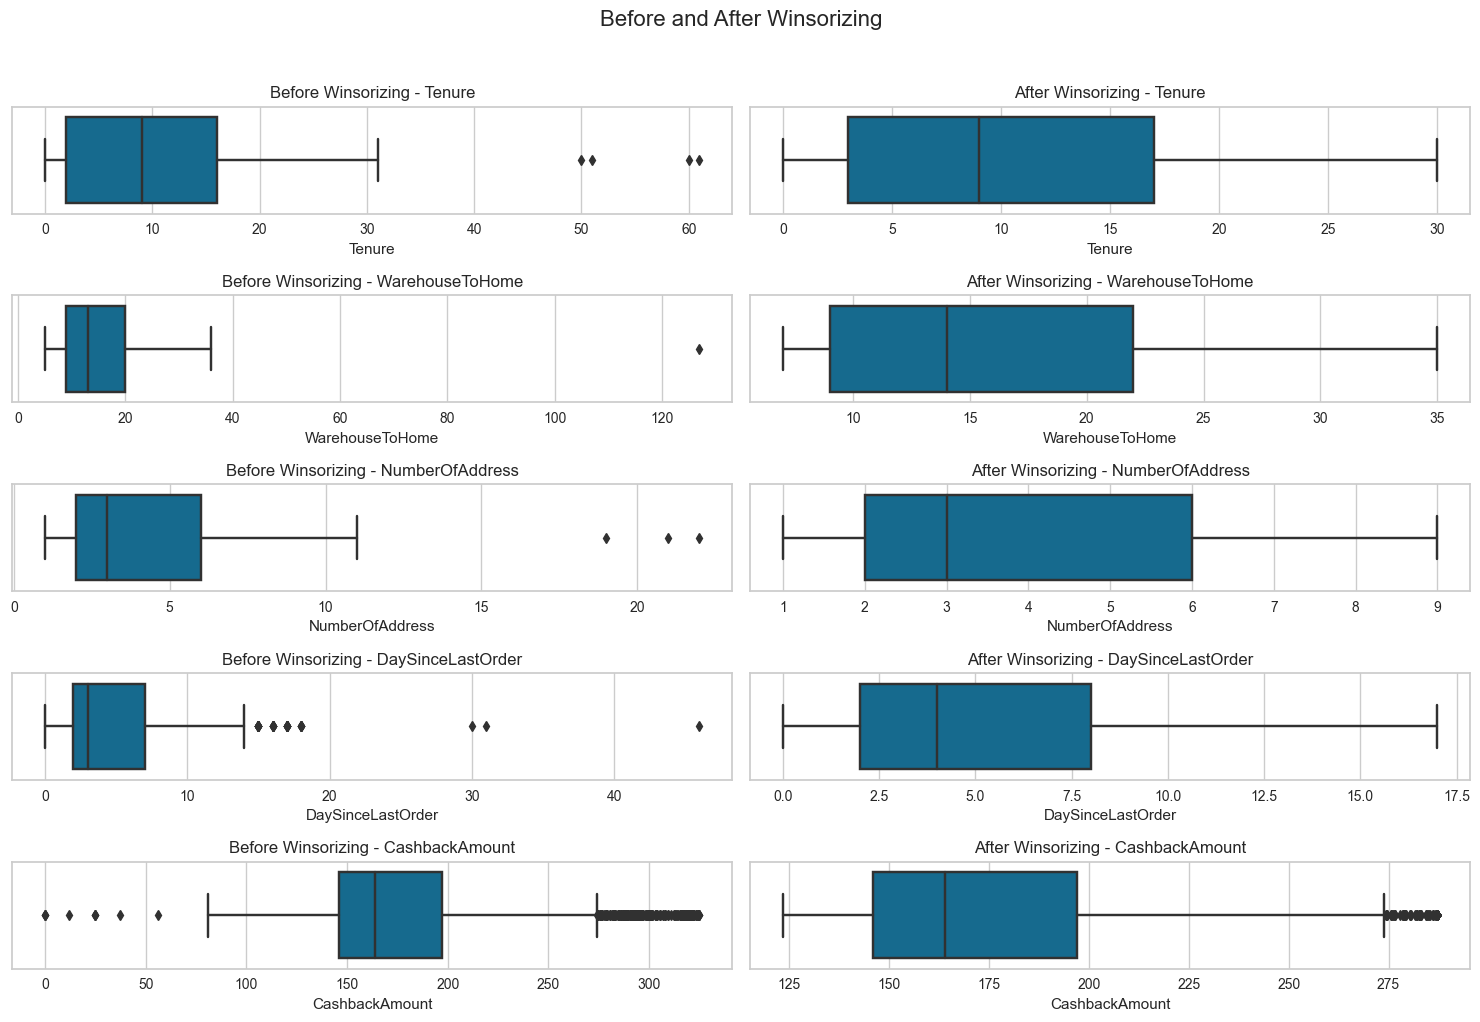

In [537]:
numeric_features = df.select_dtypes(include=['int', 'float']).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'Churn']

outlier_features = [col for col in numeric_features if col not in ['Complain', 'SatisfactionScore', 'NumberOfDeviceRegistered']]

fig, axs = plt.subplots(len(outlier_features), 2, figsize=(15, len(outlier_features) * 2))
plt.suptitle('Before and After Winsorizing', y=1.02, fontsize=16)

for i, feature in enumerate(outlier_features):
    sns.boxplot(x=feature, y=None, data=df, ax=axs[i, 0])
    axs[i, 0].set_title(f'Before Winsorizing - {feature}')

    winsorized_feature = winsorize(df[feature], limits=[0.06, 0.06])
    df_winsorized = df.copy()
    df_winsorized[feature] = winsorized_feature

    sns.boxplot(x=feature, y=None, data=df_winsorized, ax=axs[i, 1])
    axs[i, 1].set_title(f'After Winsorizing - {feature}')

plt.tight_layout()
plt.show()


After winsorizing with limit 0.06, overall outliers have significantly decreased.

## Creating Pipeline

In [538]:
categorical_features = ['PreferedOrderCat', 'MaritalStatus']
missing_val = ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']

random_seed = 20

df_seen, df_unseen = train_test_split(df, stratify = df['Churn'], test_size=0.2, random_state=random_seed)

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in X.columns:
            X[col] = winsorize(X[col], limits=(0.06, 0.06))
        return X
    
    def set_output(self, transform: Literal['default', 'pandas']):
        return super().set_output(transform=transform)

imputation = TransformerWrapper(
        include=missing_val,
        transformer = SimpleImputer(strategy='median'))

winsorizer = TransformerWrapper(
        include = outlier_features,
        transformer = Winsorizer())

transformers = ColumnTransformer(
        transformers = [
            ('imputer', SimpleImputer(strategy='median'), missing_val),
            ('scaler', StandardScaler(), numeric_features),
            ('onehot', OneHotEncoder(drop = 'first', sparse=False), categorical_features),
        ], remainder = 'passthrough')

In [539]:
preprocessor = [
    ('imputer', TransformerWrapper(
        include=missing_val,
        transformer = SimpleImputer(strategy='median'))),

    ('winsorize', TransformerWrapper(
        include = numeric_features,
        transformer = Winsorizer())),
    
    ('transformer', ColumnTransformer(
        transformers = [
            ('scaler', StandardScaler(), numeric_features),
            ('onehot', OneHotEncoder(sparse=False), categorical_features),
        ], remainder = 'passthrough').set_output(transform='pandas')),
]

pipeline = Pipeline(steps = preprocessor)
pipeline

Pipeline(memory=None,
         steps=[('imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Tenure', 'WarehouseToHome',
                                             'DaySinceLastOrder'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='median',
                                                              verbose='deprecated'))),
                ('winsorize',
                 TransformerWrapper(exclude=None,
                                    include=['Tenure',...
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('onehot',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                max_categories=None,
                                                                min_frequency=None,
                                                                sparse=False,
                                                                sparse_output=True),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])],
                                   verbose=False,
                                   verbose_feature_names_out=True))],
         verbose=False)

# Model Experiment

## Base Models

In [540]:
base = setup(
    experiment_name='Churn Classification',
    data=df_seen, 
    target='Churn', 
    train_size=0.8,
    verbose=True,

    preprocess=False,
    session_id=random_seed,
    custom_pipeline=pipeline,
    fold=5,
    fold_shuffle=False,
    fold_strategy='stratifiedkfold',
)

,Description,Value
0,Session id,20
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(2616, 11)"
4,Transformed data shape,"(2616, 18)"
5,Transformed train set shape,"(2092, 18)"
6,Transformed test set shape,"(524, 18)"
7,Numeric features,8
8,Categorical features,2
9,Rows with missing values,13.8%


Add PR-AUC as additional metric

In [541]:
add_metric('auprc', 'AUPRC', average_precision_score, target = 'pred_proba')

Name                                                             AUPRC
Display Name                                                     AUPRC
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(average_precision_score, needs_pro...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: auprc, dtype: object

Due to the highly imbalanced data, we will focus on f1 as the evaluation metric, as F1 score, being a balanced metric of precision and recall, is well-suited for imbalanced datasets.

In [542]:
base_models = compare_models(sort='f1', errors='raise')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:37:39
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC,TT (Sec)
catboost,CatBoost Classifier,0.9073,0.9327,0.6071,0.7771,0.6800,0.6269,0.6344,0.7542,1.3360
xgboost,Extreme Gradient Boosting,0.9001,0.9173,0.6275,0.7220,0.6699,0.6116,0.6146,0.7209,0.0840
lightgbm,Light Gradient Boosting Machine,0.8972,0.9241,0.6129,0.7155,0.6580,0.5982,0.6020,0.7374,0.1760
gbc,Gradient Boosting Classifier,0.8901,0.9182,0.5307,0.7227,0.6115,0.5492,0.5584,0.7146,0.1940
ada,Ada Boost Classifier,0.8886,0.8953,0.5336,0.7112,0.6084,0.5452,0.5535,0.6898,0.1160
rf,Random Forest Classifier,0.8910,0.9210,0.5101,0.7387,0.6025,0.5420,0.5550,0.7257,0.1720
et,Extra Trees Classifier,0.8853,0.9147,0.4604,0.7429,0.5666,0.5047,0.5249,0.6859,0.1560
dt,Decision Tree Classifier,0.8580,0.7404,0.5658,0.5649,0.5643,0.4797,0.4803,0.3935,0.0480
lda,Linear Discriminant Analysis,0.8819,0.8752,0.4544,0.7184,0.5549,0.4911,0.5091,0.6532,0.0480
lr,Logistic Regression,0.8748,0.8779,0.4397,0.6796,0.5333,0.4649,0.4799,0.6626,1.2160


* The CatBoost Classifier demonstrates the overall best performance with the highest Accuracy (0.91), ROC AUC (0.93), F1 Score (0.68), and AU-PRC (0.75), followed by xgboost and lightgbm.

* However, the CatBoost Classifier is inefficient to tune in terms of time complexity compared to Extreme Gradient Boosting, which only has slightly lower performance overall, but takes significantly less time (0.05 Time taken (sec)) compared to catboost (0.7080 time taken (sec)).

* The random forest bagging algorithm also has a good performance, although slightly worse than most of the boosting algorithms excluding adaboost.

## Hyperparameter Tuning & Imbalanced Classification
For this section, we will choose 2 ensemble models and 2 standalone models to tune.
* For the ensemble models, we will use Extreme Gradient Boosting Classifier and Random Forest.
* For the standalone models, we will use Logistic Regression and KNN.

* **Extreme Gradient Boosting**: XGBoost is an optimized gradient boosting algorithm that is widely used for regression tasks. It sequentially builds a series of decision trees, correcting errors of the previous ones, and combines their predictions
* **Random Forest**: Random Forest is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mean prediction of the individual trees for regression tasks. It helps reduce overfitting and improves accuracy.
* **Logistic Regression**: Logistic Regression is a statistical method for binary classification that models the probability of an event occurring. It uses the logistic function to transform input features and predict the likelihood of the event.
* **K-Nearest Neighbors**: KNN is a non-parametric algorithm used for regression tasks. It predicts the output based on the average of the 'k' nearest data points in the feature space.

In [598]:
base4_models = compare_models(include=['xgboost', 'rf', 'lr', 'knn'], sort = 'f1')
base_pull = pull()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:48:53
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC,Profit,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8958,0.9180,0.6597,0.6890,0.6727,0.6109,0.6119,0.7226,1020.0000,2.8840
rf,Random Forest Classifier,0.8886,0.9116,0.6391,0.6649,0.6509,0.5847,0.5854,0.6743,764.8000,0.9160
knn,K Neighbors Classifier,0.8203,0.8699,0.8180,0.4719,0.5979,0.4930,0.5243,0.5771,-2485.6000,0.0460
lr,Logistic Regression,0.7968,0.8685,0.8064,0.4374,0.5654,0.4486,0.4855,0.6327,-3440.0000,0.0300


### Setup Environment

In [544]:
transformers = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numeric_features),
        ('onehot', OneHotEncoder(drop='first', sparse=False), categorical_features),
    ], remainder='passthrough'
)

In [545]:
configs = {
    'data': df_seen, 
    'target': 'Churn', 
    'train_size': 0.8,
    'verbose': False,
    'preprocess': False,
    'imputation_type': None,
    'session_id': random_seed, 
    'custom_pipeline_position': 0,
    'fold': 5,
    'fold_shuffle': False,
    'fold_strategy': 'stratifiedkfold',
} 

In [546]:
penalize = ClassificationExperiment()
penalize.setup(
    experiment_name='No Resampling', 
    custom_pipeline=pipeline, 
    **configs)

In [547]:
smote_experiment = ClassificationExperiment()
smote_experiment.setup(
    experiment_name='SMOTE Resampling',
    custom_pipeline=[
        ('imputer', TransformerWrapper(include = missing_val, transformer=SimpleImputer(strategy='median'))),
        ('winsorize', TransformerWrapper(include = outlier_features, transformer = Winsorizer())),
        ('preprocessing', TransformerWrapper(transformer=transformers)),
        ('resampling', TransformerWrapper(transformer=FixImbalancer(SMOTE(random_state=random_seed)))),
    ],
    **configs
)

In [548]:
nearmiss_experiment = ClassificationExperiment()
nearmiss_experiment.setup(
    experiment_name='NearMiss Resampling',
    custom_pipeline=[
        ('imputer', TransformerWrapper(include = missing_val, transformer=SimpleImputer(strategy='median'))),
        ('winsorize', TransformerWrapper(include = outlier_features, transformer = Winsorizer())),
        ('preprocessing', TransformerWrapper(transformer=transformers)),
        ('resampling', TransformerWrapper(transformer=FixImbalancer(NearMiss(version=3)))),
    ],
    **configs
)

### 1. Extreme Gradient Boosting Classifier

**Hyperparameters**

In [549]:
xgb_param = {
    'max_depth': [None, 10, 20, 30], 
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1, 10],
}

#### 1.1 First Experiment (With Penalize)

In [550]:
penalize_xgb = penalize.create_model('xgboost', class_weight = 'balanced', verbose=False)

penalize_tuned_xgb = penalize.tune_model(
    estimator=penalize_xgb, 
    optimize='f1', 
    custom_grid=xgb_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=False
)

#### 1.2 Second Experiment (With SMOTE Resampling)

In [551]:
smote_xgb = smote_experiment.create_model('xgboost', verbose=False)

smote_tuned_xgb = smote_experiment.tune_model(
    estimator=smote_xgb, 
    optimize='f1', 
    custom_grid=xgb_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=False
)

#### 1.3 Third Experiment (With NearMiss Resampling)

In [552]:
nearmiss_xgb = nearmiss_experiment.create_model('xgboost', verbose=False)

nearmiss_tuned_xgb = nearmiss_experiment.tune_model(
    estimator=smote_xgb, 
    optimize='f1', 
    custom_grid=xgb_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=False
)

#### 1.4 Fourth Experiment (Base Model)

In [553]:
model_xgb = create_model('xgboost', verbose=False)

tuned_xgb = tune_model(
    estimator=model_xgb, 
    optimize='f1', 
    custom_grid=xgb_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=True
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
Fold,,,,,,,,
0,0.8878,0.9080,0.5441,0.6981,0.6116,0.5472,0.5530,0.6477
1,0.9189,0.9392,0.6667,0.8070,0.7302,0.6829,0.6872,0.8124
2,0.8780,0.8811,0.5441,0.6491,0.5920,0.5209,0.5237,0.6041
3,0.9306,0.9503,0.7353,0.8197,0.7752,0.7343,0.7358,0.8535
4,0.9019,0.9243,0.6471,0.7213,0.6822,0.6244,0.6257,0.7474
Mean,0.9034,0.9206,0.6275,0.7390,0.6782,0.6219,0.6251,0.7330
Std,0.0193,0.0243,0.0741,0.0651,0.0693,0.0802,0.0795,0.0948


Fitting 5 folds for each of 80 candidates, totalling 400 fits


#### Compare Extreme Gradient Boosting Models

In [554]:
compare = pd.concat(
    [
        penalize.pull().loc['Mean':, :],
        smote_experiment.pull().loc['Mean':, :],
        nearmiss_experiment.pull().loc['Mean':, :]
    ]
    ,axis=0
)
compare.index = [
    'Penalize Mean', 'Penalize Std',
    'SMOTE Mean', 'SMOTE Std',
    'NearMiss Mean', 'NearMiss Std'
]
print('Extreme Gradient Boosting Classifier:')
display(compare)

Extreme Gradient Boosting Classifier:


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Penalize Mean,0.9034,0.9206,0.6275,0.7390,0.6782,0.6219,0.6251
Penalize Std,0.0193,0.0243,0.0741,0.0651,0.0693,0.0802,0.0795
SMOTE Mean,0.9001,0.9124,0.6509,0.7145,0.6801,0.6211,0.6228
SMOTE Std,0.0208,0.0300,0.0644,0.0826,0.0660,0.0783,0.0794
NearMiss Mean,0.8327,0.8906,0.8122,0.4947,0.6132,0.5149,0.5419
NearMiss Std,0.0242,0.0367,0.0748,0.0419,0.0439,0.0562,0.0583


* Penalizing using class_weight = 'balanced' does not affect the xgboost model.
* SMOTE resampling seem to have the highest improvement on the model performance. SMOTE increased the model's F1 Score from 0.6782 with only tuning, to 0.6801.

In [555]:
print('Before Tuning')
create_model('xgboost')
print('After Tuning with SMOTE')
compare = pd.concat(
    [
        smote_experiment.pull().loc['Mean':, :],
    ]
    ,axis=0
)
compare.index = [
    'SMOTE Mean', 'SMOTE Std',
]
display(compare)

Before Tuning


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:43:11
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
Fold,,,,,,,,
0,0.8807,0.9101,0.5294,0.6667,0.5902,0.5214,0.5262,0.6092
1,0.9212,0.9383,0.6522,0.8333,0.7317,0.6864,0.6934,0.8194
2,0.8732,0.8766,0.5294,0.6316,0.5760,0.5021,0.5048,0.6211
3,0.9306,0.9476,0.7794,0.7910,0.7852,0.7438,0.7438,0.8310
4,0.8947,0.9138,0.6471,0.6875,0.6667,0.6042,0.6046,0.7237
Mean,0.9001,0.9173,0.6275,0.7220,0.6699,0.6116,0.6146,0.7209
Std,0.0224,0.0248,0.0931,0.0769,0.0804,0.0930,0.0926,0.0941


After Tuning with SMOTE


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
SMOTE Mean,0.9001,0.9124,0.6509,0.7145,0.6801,0.6211,0.6228
SMOTE Std,0.0208,0.0300,0.0644,0.0826,0.0660,0.0783,0.0794


Hyperparameter tuning along with SMOTE increases the XGBoost Model performance significantly in terms of F1 Score.

### 2. Random Forest Classifier

**Hyperparameters**

In [556]:
rf_param = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 10, 20, 30],
}

#### 2.1 First Experiment (With Penalize)

In [557]:
penalize_rf = penalize.create_model('rf', class_weight = 'balanced', verbose=False)

penalize_tuned_rf = penalize.tune_model(
    estimator=penalize_rf, 
    optimize='f1', 
    custom_grid=rf_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=False
)

#### 2.2 Second Experiment (With SMOTE Resampling)

In [558]:
smote_rf = smote_experiment.create_model('rf', verbose=False)

smote_tuned_rf = smote_experiment.tune_model(
    estimator=smote_rf, 
    optimize='f1', 
    custom_grid=rf_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=False
)

#### 2.3 Third Experiment (With NearMiss Resampling)

In [559]:
nearmiss_rf = nearmiss_experiment.create_model('rf', verbose=False)

nearmiss_tuned_rf = nearmiss_experiment.tune_model(
    estimator=nearmiss_rf, 
    optimize='f1', 
    custom_grid=rf_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=False
)

#### 2.4 Fourth Experiment (Base Model)

In [560]:
model_rf = create_model('rf', verbose=False)

tuned_rf = tune_model(
    estimator=model_rf, 
    optimize='f1', 
    custom_grid=rf_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=True
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
Fold,,,,,,,,
0,0.8711,0.9109,0.4265,0.6591,0.5179,0.4474,0.4615,0.6298
1,0.9189,0.9431,0.6087,0.8571,0.7119,0.6662,0.6794,0.8118
2,0.8732,0.8810,0.4265,0.6744,0.5225,0.4537,0.4695,0.6193
3,0.9211,0.9442,0.5882,0.8889,0.7080,0.6645,0.6834,0.8522
4,0.8995,0.9161,0.5735,0.7500,0.6500,0.5926,0.5998,0.7038
Mean,0.8968,0.9191,0.5247,0.7659,0.6220,0.5649,0.5788,0.7234
Std,0.0214,0.0234,0.0810,0.0933,0.0860,0.0971,0.0972,0.0942


Fitting 5 folds for each of 48 candidates, totalling 240 fits


#### Compare Random Forest Models

In [561]:
compare = pd.concat(
    [
        penalize.pull().loc['Mean':, :],
        smote_experiment.pull().loc['Mean':, :],
        nearmiss_experiment.pull().loc['Mean':, :]
    ]
    ,axis=0
)
compare.index = [
    'Penalize Mean', 'Penalize Std',
    'SMOTE Mean', 'SMOTE Std',
    'NearMiss Mean', 'NearMiss Std'
]

print('Random Forest Classifier:')
display(compare)

Random Forest Classifier:


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Penalize Mean,0.8939,0.9167,0.6010,0.7049,0.6483,0.5863,0.5892
Penalize Std,0.0185,0.0211,0.0621,0.0690,0.0630,0.0736,0.0737
SMOTE Mean,0.8910,0.9043,0.6480,0.6739,0.6602,0.5954,0.5958
SMOTE Std,0.0183,0.0273,0.0478,0.0661,0.0541,0.0650,0.0653
NearMiss Mean,0.8356,0.8843,0.8035,0.5001,0.6156,0.5185,0.5426
NearMiss Std,0.0231,0.0287,0.0423,0.0437,0.0400,0.0526,0.0503


SMOTE resampling seem to have the highest improvement on the model performance, especially in terms of F1 Score, from 0.62 with only tuning, to 0.66.

In [562]:
print('Before Tuning:')
create_model('rf')
print('After Tuning with SMOTE:')
compare = pd.concat(
    [
        smote_experiment.pull().loc['Mean':, :],
    ]
    ,axis=0
)
compare.index = [
    'SMOTE Mean', 'SMOTE Std',
]
display(compare)

Before Tuning:


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
Fold,,,,,,,,
0,0.8663,0.9140,0.3824,0.6500,0.4815,0.4106,0.4297,0.6439
1,0.9045,0.9520,0.5507,0.8085,0.6552,0.6021,0.6170,0.8267
2,0.8708,0.8873,0.4559,0.6458,0.5345,0.4621,0.4715,0.6147
3,0.9211,0.9408,0.6029,0.8723,0.7130,0.6690,0.6844,0.8463
4,0.8923,0.9109,0.5588,0.7170,0.6281,0.5663,0.5723,0.6970
Mean,0.8910,0.9210,0.5101,0.7387,0.6025,0.5420,0.5550,0.7257
Std,0.0205,0.0230,0.0799,0.0891,0.0836,0.0938,0.0933,0.0944


After Tuning with SMOTE:


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
SMOTE Mean,0.8910,0.9043,0.6480,0.6739,0.6602,0.5954,0.5958
SMOTE Std,0.0183,0.0273,0.0478,0.0661,0.0541,0.0650,0.0653


Hyperparameter tuning along with SMOTE increases the Random Forest Model performance significantly in terms of F1 Score.

### 3. Logistic Regression

**Hyperparameters**

In [563]:
lr_param = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
}

#### 3.1 First Experiment (With Penalize)

In [564]:
penalize_lr = penalize.create_model('lr', class_weight = 'balanced', verbose=False)

penalize_tuned_lr = penalize.tune_model(
    estimator=penalize_lr, 
    optimize='f1', 
    custom_grid=lr_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=False
)

#### 3.2 Second Experiment (With SMOTE)

In [565]:
smote_lr = smote_experiment.create_model('lr', verbose=False)

smote_tuned_lr = smote_experiment.tune_model(
    estimator=smote_lr, 
    optimize='f1', 
    custom_grid=lr_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=False
)

#### 3.3 Third Experiment (With NearMiss)

In [566]:
nearmiss_lr = nearmiss_experiment.create_model('lr', verbose=False)

nearmiss_tuned_lr = nearmiss_experiment.tune_model(
    estimator=nearmiss_lr, 
    optimize='f1', 
    custom_grid=lr_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=False
)

#### 3.4 Fourth Experiment (Base Model)

In [567]:
model_lr = create_model('lr', verbose=False)

tuned_lr = tune_model(
    estimator=model_lr, 
    optimize='f1', 
    custom_grid=lr_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=True
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
Fold,,,,,,,,
0,0.8616,0.8621,0.4559,0.5962,0.5167,0.4376,0.4429,0.6294
1,0.8926,0.9114,0.4928,0.7727,0.6018,0.5432,0.5616,0.7630
2,0.8636,0.8478,0.3676,0.6410,0.4673,0.3956,0.4158,0.5618
3,0.8828,0.9120,0.4706,0.7111,0.5664,0.5018,0.5161,0.7103
4,0.8780,0.8675,0.4706,0.6809,0.5565,0.4885,0.4997,0.6624
Mean,0.8757,0.8802,0.4515,0.6804,0.5417,0.4733,0.4872,0.6654
Std,0.0117,0.0265,0.0435,0.0602,0.0460,0.0515,0.0521,0.0687


Fitting 5 folds for each of 16 candidates, totalling 80 fits


#### Compare Logistic Regression Models

In [568]:
compare = pd.concat(
    [
        penalize.pull().loc['Mean':, :],
        smote_experiment.pull().loc['Mean':, :],
        nearmiss_experiment.pull().loc['Mean':, :]
    ]
    ,axis=0
)
compare.index = [
    'Penalize Mean', 'Penalize Std',
    'SMOTE Mean', 'SMOTE Std',
    'NearMiss Mean', 'NearMiss Std'
]

print('Logistic Regression Classifier:')
display(compare)

Logistic Regression Classifier:


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Penalize Mean,0.7949,0.8780,0.8210,0.4346,0.5670,0.4496,0.4895
Penalize Std,0.0218,0.0241,0.0473,0.0312,0.0260,0.0359,0.0331
SMOTE Mean,0.8002,0.8771,0.8004,0.4388,0.5663,0.4507,0.4855
SMOTE Std,0.0156,0.0248,0.0520,0.0253,0.0295,0.0373,0.0402
NearMiss Mean,0.7897,0.8558,0.7681,0.4202,0.5428,0.4210,0.4539
NearMiss Std,0.0063,0.0261,0.0590,0.0126,0.0233,0.0265,0.0343


Penalize seem to have the highest improvement on the model performance, especially in terms of F1 Score, from 0.54 with only tuning, to 0.57.

In [569]:
print('Before Tuning:')
create_model('lr')
print('After Tuning with Penalize:')
compare = pd.concat(
    [
        penalize.pull().loc['Mean':, :],
    ]
    ,axis=0
)
compare.index = [
    'Penalize Mean', 'Penalize Std',
]
display(compare)

Before Tuning:


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
Fold,,,,,,,,
0,0.8616,0.8620,0.4412,0.6000,0.5085,0.4301,0.4370,0.6327
1,0.8926,0.9061,0.4928,0.7727,0.6018,0.5432,0.5616,0.7581
2,0.8565,0.8429,0.3529,0.6000,0.4444,0.3683,0.3855,0.5538
3,0.8804,0.9060,0.4412,0.7143,0.5455,0.4810,0.4995,0.6995
4,0.8828,0.8727,0.4706,0.7111,0.5664,0.5018,0.5161,0.6690
Mean,0.8748,0.8779,0.4397,0.6796,0.5333,0.4649,0.4799,0.6626
Std,0.0136,0.0249,0.0475,0.0686,0.0537,0.0605,0.0619,0.0682


After Tuning with Penalize:


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Penalize Mean,0.7949,0.8780,0.8210,0.4346,0.5670,0.4496,0.4895
Penalize Std,0.0218,0.0241,0.0473,0.0312,0.0260,0.0359,0.0331


Hyperparameter tuning along with Penalization increases the Logistic Regression Model performance significantly in terms of F1 Score.

### 4. KNN Classifier

**Hyperparameters**

In [570]:
knn_param = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

As KNN does not support penalize, we will skip the Penalize Experiment.

#### 4.1 First Experiment (With SMOTE)

In [571]:
smote_knn = smote_experiment.create_model('knn', verbose=False)

smote_tuned_knn = smote_experiment.tune_model(
    estimator=smote_knn, 
    optimize='f1', 
    custom_grid=knn_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=False
)

#### 4.2 Second Experiment (With NearMiss)

In [572]:
nearmiss_knn = nearmiss_experiment.create_model('knn', verbose=False)

nearmiss_tuned_knn = nearmiss_experiment.tune_model(
    estimator=nearmiss_knn, 
    optimize='f1', 
    custom_grid=knn_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=False
)

#### 4.3 Third Experiment (Base Model)

In [573]:
model_knn = create_model('knn', verbose=False)

tuned_knn = tune_model(
    estimator=model_knn, 
    optimize='f1', 
    custom_grid=knn_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=True
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
Fold,,,,,,,,
0,0.8592,0.8114,0.4412,0.5882,0.5042,0.4241,0.4301,0.4741
1,0.8998,0.8768,0.4928,0.8293,0.6182,0.5648,0.5901,0.7301
2,0.8660,0.8087,0.4265,0.6304,0.5088,0.4345,0.4457,0.5169
3,0.8947,0.8517,0.5882,0.7143,0.6452,0.5840,0.5878,0.6723
4,0.8684,0.8247,0.4265,0.6444,0.5133,0.4408,0.4534,0.5443
Mean,0.8776,0.8347,0.4750,0.6813,0.5579,0.4896,0.5014,0.5875
Std,0.0164,0.0260,0.0616,0.0844,0.0609,0.0697,0.0719,0.0972


Fitting 5 folds for each of 20 candidates, totalling 100 fits


#### Compare KNN Models

In [574]:
compare = pd.concat(
    [
        smote_experiment.pull().loc['Mean':, :],
        nearmiss_experiment.pull().loc['Mean':, :]
    ]
    ,axis=0
)
compare.index = [
    'SMOTE Mean', 'SMOTE Std',
    'NearMiss Mean', 'NearMiss Std'
]

print('KNN Classifier:')
display(compare)

KNN Classifier:


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
SMOTE Mean,0.8552,0.8307,0.6567,0.5472,0.5965,0.5093,0.5127
SMOTE Std,0.0185,0.0336,0.0563,0.0514,0.0507,0.0617,0.0619
NearMiss Mean,0.7433,0.8151,0.7712,0.3645,0.4944,0.3509,0.3959
NearMiss Std,0.0121,0.0268,0.0550,0.0095,0.0148,0.0173,0.0245


SMOTE and NearMiss causes the model to perform worse overall.

In [575]:
print('Before Tuning:')
create_model('knn')
print('After Tuning with SMOTE:')
compare = pd.concat(
    [
        smote_experiment.pull().loc['Mean':, :],
    ]
    ,axis=0
)
compare.index = [
    'SMOTE Mean', 'SMOTE Std',
]
display(compare)

Before Tuning:


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:47:04
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
Fold,,,,,,,,
0,0.8640,0.8163,0.4265,0.6170,0.5043,0.4285,0.4384,0.4934
1,0.8854,0.8619,0.4058,0.8000,0.5385,0.4809,0.5172,0.5851
2,0.8565,0.7752,0.3529,0.6000,0.4444,0.3683,0.3855,0.4315
3,0.8636,0.8637,0.3824,0.6341,0.4771,0.4041,0.4213,0.5309
4,0.8541,0.8354,0.3088,0.6000,0.4078,0.3342,0.3582,0.4975
Mean,0.8647,0.8305,0.3753,0.6502,0.4744,0.4032,0.4241,0.5077
Std,0.0111,0.0328,0.0413,0.0759,0.0455,0.0503,0.0542,0.0503


After Tuning with SMOTE:


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
SMOTE Mean,0.8552,0.8307,0.6567,0.5472,0.5965,0.5093,0.5127
SMOTE Std,0.0185,0.0336,0.0563,0.0514,0.0507,0.0617,0.0619


Hyperparameter tuning and SMOTE increases the KNN model performance significantly in terms of F1 Score.

## Model Selection

After tuning the 4 models above, we will compare the tuned models to use for the final model.

In [576]:
compare_models(include=[smote_tuned_knn, penalize_tuned_lr, smote_tuned_rf, smote_tuned_xgb], sort = 'f1', round = 3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:47:06
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC,TT (Sec)
3,Extreme Gradient Boosting,0.901,0.920,0.633,0.724,0.675,0.617,0.619,0.729,0.154
2,Random Forest Classifier,0.897,0.919,0.525,0.766,0.622,0.565,0.579,0.723,0.118
1,Logistic Regression,0.795,0.878,0.821,0.435,0.567,0.450,0.490,0.661,0.056
0,K Neighbors Classifier,0.878,0.835,0.475,0.681,0.558,0.490,0.501,0.588,0.068


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

After hyperparameter tuning, we can obtain the following insights:
* All the models' performance have improved overall after hyperparameter tuning.
* Extreme Gradient Boosting still has the best overall performance.

Based on these insights, Extreme Gradient Boosting seem to be the best choice as our final model, as it has the best performance overall while having a reasonable amount of training time.

## Feature Selection

### Wrapper Method

**Forward**

In [577]:
from mlxtend.feature_selection import SequentialFeatureSelector

model_xgb = create_model('xgboost', verbose = False)
forward = SequentialFeatureSelector(
    estimator=model_xgb,
    k_features='best', 
    forward=True, 
    verbose=0,
    scoring='f1',
    cv=5,
)

forward.fit(get_config('X_train_transformed'), (get_config('y_train')))

best_feature = pd.DataFrame.from_dict(forward.get_metric_dict()).T

In [578]:
best_feature.sort_values(by='avg_score', ascending=False)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
14,"(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 15, 16)","[0.6218487394957983, 0.752, 0.5891472868217055...",0.6878,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.0967,0.0752,0.0376
16,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,...","[0.6341463414634145, 0.7401574803149606, 0.580...",0.6873,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.0970,0.0754,0.0377
15,"(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15...","[0.6065573770491803, 0.7131782945736433, 0.582...",0.6692,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.0852,0.0663,0.0331
13,"(0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 15, 16)","[0.5901639344262295, 0.7419354838709676, 0.598...",0.6669,"(scaler__Tenure, scaler__NumberOfDeviceRegiste...",0.0946,0.0736,0.0368
17,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.5619834710743802, 0.7244094488188977, 0.580...",0.6655,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.1050,0.0817,0.0408
12,"(0, 2, 3, 4, 5, 6, 7, 9, 11, 13, 15, 16)","[0.5891472868217055, 0.7096774193548386, 0.587...",0.6599,"(scaler__Tenure, scaler__NumberOfDeviceRegiste...",0.0837,0.0651,0.0326
11,"(0, 2, 3, 4, 5, 6, 7, 9, 11, 13, 15)","[0.5826771653543307, 0.7, 0.5692307692307692, ...",0.6401,"(scaler__Tenure, scaler__NumberOfDeviceRegiste...",0.0700,0.0545,0.0272
10,"(0, 2, 3, 4, 5, 6, 9, 11, 13, 15)","[0.5333333333333333, 0.6341463414634146, 0.528...",0.6065,"(scaler__Tenure, scaler__NumberOfDeviceRegiste...",0.0918,0.0714,0.0357
9,"(0, 2, 4, 5, 6, 9, 11, 13, 15)","[0.4958677685950413, 0.5984251968503937, 0.491...",0.5712,"(scaler__Tenure, scaler__NumberOfDeviceRegiste...",0.0934,0.0727,0.0363
8,"(0, 2, 4, 6, 9, 11, 13, 15)","[0.5238095238095238, 0.5873015873015873, 0.503...",0.5513,"(scaler__Tenure, scaler__NumberOfDeviceRegiste...",0.0499,0.0388,0.0194


**Backward**

In [579]:
backward = SequentialFeatureSelector(
    estimator=model_xgb,
    k_features='best', 
    forward=False, 
    verbose=0,
    scoring='f1',
    cv=5
)

backward.fit(get_config('X_train_transformed'), (get_config('y_train')))

best_feature = pd.DataFrame.from_dict(backward.get_metric_dict()).T

In [580]:
best_feature.sort_values(by='avg_score', ascending=False)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
13,"(0, 1, 3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 16)","[0.6341463414634145, 0.7419354838709676, 0.630...",0.6953,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.0862,0.0671,0.0335
15,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15...","[0.6349206349206349, 0.752, 0.596774193548387,...",0.6930,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.0934,0.0727,0.0363
16,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,...","[0.6341463414634145, 0.7401574803149606, 0.580...",0.6873,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.0970,0.0754,0.0377
14,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 16)","[0.5999999999999999, 0.7741935483870968, 0.566...",0.6815,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.1120,0.0872,0.0436
12,"(0, 1, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16)","[0.6129032258064516, 0.752, 0.578125, 0.75, 0....",0.6789,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.0916,0.0713,0.0357
10,"(0, 1, 3, 4, 5, 6, 7, 8, 14, 15)","[0.6341463414634145, 0.746031746031746, 0.5826...",0.6737,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.0801,0.0623,0.0312
11,"(0, 1, 3, 4, 5, 6, 7, 8, 14, 15, 16)","[0.6511627906976745, 0.7200000000000001, 0.573...",0.6716,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.0790,0.0615,0.0307
17,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.5619834710743802, 0.7244094488188977, 0.580...",0.6655,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.1050,0.0817,0.0408
9,"(0, 1, 3, 4, 5, 6, 7, 14, 15)","[0.6239999999999999, 0.6929133858267716, 0.580...",0.6593,"(scaler__Tenure, scaler__WarehouseToHome, scal...",0.0664,0.0517,0.0258
7,"(0, 3, 4, 5, 6, 7, 15)","[0.5999999999999999, 0.6976744186046512, 0.545...",0.6413,"(scaler__Tenure, scaler__SatisfactionScore, sc...",0.0863,0.0672,0.0336


In [581]:
best_feature_col = list(best_feature.loc[13, 'feature_names'])
best_feature_col

['scaler__Tenure',
 'scaler__WarehouseToHome',
 'scaler__SatisfactionScore',
 'scaler__NumberOfAddress',
 'scaler__Complain',
 'scaler__DaySinceLastOrder',
 'scaler__CashbackAmount',
 'onehot__PreferedOrderCat_Fashion',
 'onehot__PreferedOrderCat_Laptop & Accessory',
 'onehot__PreferedOrderCat_Others',
 'onehot__MaritalStatus_Divorced',
 'onehot__MaritalStatus_Married',
 'onehot__MaritalStatus_Single']

In [582]:
drop_col = list(set(get_config('X_train_transformed')) - set(best_feature_col))
drop_col

['onehot__PreferedOrderCat_Mobile',
 'scaler__NumberOfDeviceRegistered',
 'onehot__PreferedOrderCat_Mobile Phone',
 'onehot__PreferedOrderCat_Grocery']

In [583]:
feature_selector = ColumnTransformer(
    transformers=[
        ('feature_selection', 'drop', drop_col)
    ],
    remainder="passthrough", 
    verbose_feature_names_out=False)

In [584]:
base = setup(
    experiment_name='Churn Classification',
    data=df_seen, 
    target='Churn', 
    train_size=0.8,
    verbose=True,

    preprocess=False,
    session_id=random_seed,
    custom_pipeline=[
        ('imputer', TransformerWrapper(include = missing_val, transformer=SimpleImputer(strategy='median'))),
        ('winsorize', TransformerWrapper(include = outlier_features, transformer = Winsorizer())),
        ('preprocessing', TransformerWrapper(transformer=transformers)),
        ('feature_selection', TransformerWrapper(transformer=feature_selector)),
        ('resampling', TransformerWrapper(transformer=FixImbalancer(SMOTE(random_state=random_seed)))),
    ],
    fold=5,
    fold_shuffle=False,
    fold_strategy='stratifiedkfold',
)

,Description,Value
0,Session id,20
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(2616, 11)"
4,Transformed data shape,"(4026, 12)"
5,Transformed train set shape,"(3502, 12)"
6,Transformed test set shape,"(524, 12)"
7,Numeric features,8
8,Categorical features,2
9,Rows with missing values,13.8%


In [585]:
add_metric('auprc', 'AUPRC', average_precision_score, target = 'pred_proba')

Name                                                             AUPRC
Display Name                                                     AUPRC
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(average_precision_score, needs_pro...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: auprc, dtype: object

In [586]:
xgb_final = create_model('xgboost', verbose = False)

final_model = tune_model(
    estimator=xgb_final, 
    optimize='f1', 
    custom_grid=xgb_param, 
    search_library='scikit-learn',
    search_algorithm='grid', 
    return_train_score=False,
    verbose=True
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC
Fold,,,,,,,,
0,0.8878,0.9005,0.6324,0.6615,0.6466,0.5800,0.5802,0.6310
1,0.9165,0.9273,0.7101,0.7656,0.7368,0.6873,0.6880,0.7889
2,0.8660,0.8618,0.6176,0.5833,0.6000,0.5196,0.5199,0.5997
3,0.9187,0.9351,0.7941,0.7297,0.7606,0.7117,0.7126,0.7889
4,0.8923,0.8933,0.6912,0.6620,0.6763,0.6117,0.6119,0.7084
Mean,0.8963,0.9036,0.6891,0.6804,0.6841,0.6221,0.6225,0.7034
Std,0.0195,0.0262,0.0629,0.0630,0.0586,0.0702,0.0705,0.0783


Fitting 5 folds for each of 80 candidates, totalling 400 fits


* Feature selection causes a slight increase on the overall performance of the final model.
* Feature selection is useful in simplifying the model and increasing model efficiency.

## Final Model Evaluation

**Learning Curve**

Final model with feature selection:


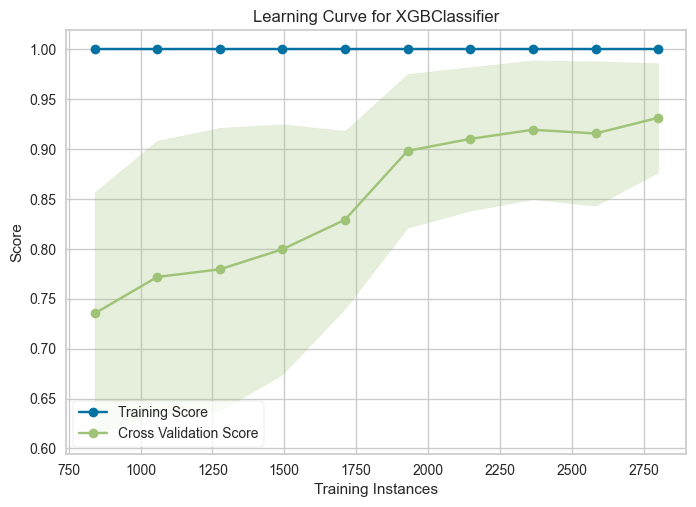

In [587]:
print("Final model with feature selection:")
plot_model(estimator=final_model, plot='learning')

* The learning curve suggests potential overfitting in the final model, as training score achieves a perfect training score of 1, while cross-validation score starts at approximately 0.75 when the number of training instances is around 750, gradually increasing with additional instances. 
* Possible solutions for mitigating overfitting could be to consider expanding the training set, reduce complexity of the model, and further feature selection.

**Decision Boundary**

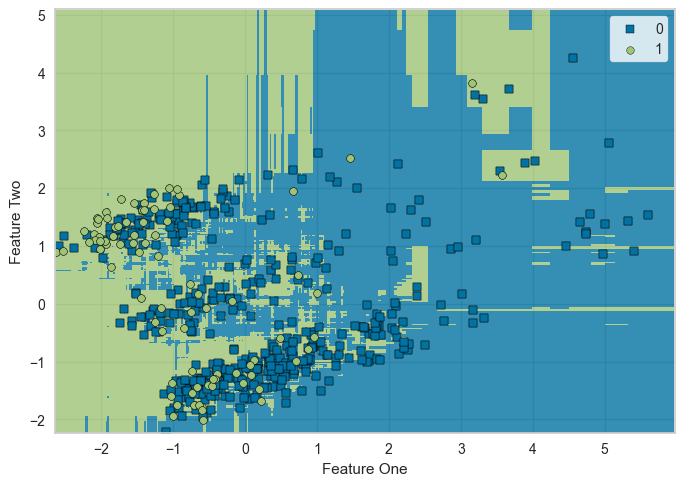

In [588]:
plot_model(final_model, plot='boundary')

The complex decision boundary may indicate that the model is overfitting.

**Data Validation Prediction**

In [596]:
validation_prediction = predict_model(final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC,Profit
0,Extreme Gradient Boosting,0.9084,0.9310,0.7791,0.6979,0.7363,0.6810,0.6825,0.7863,1656


* From the validation prediction above, the final model performance against the validation data is significantly higher compared to the model performance after tuning process.
* Accuracy from 0.896 to 0.908, ROC AUC from 0.903 to 0.931, Recall from 0.689 to 0.779, Precision from 0.680 to 0.698, F1 Score from 0.684 to 0.736, and AUPRC from 0.703 to 0.799.

## Finalize Model

In [590]:
xgb_model_final = finalize_model(final_model)
xgb_model_final

Pipeline(memory=Memory(location=None),
         steps=[('imputer',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['Tenure',
                                                                            'WarehouseToHome',
                                                                            'DaySinceLastOrder'],
                                                                   transformer=SimpleImputer(add_indicator=False,
                                                                                             copy=True,
                                                                                             fill_value=None,
                                                                                             keep_empty_features=False,
                                                                                             missing_values=nan,
                                                                                             strategy='median',
                                                                                             verbose='depr...
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=20, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='binary:logistic', ...))],
         verbose=False)

The following explains the work process of the final model:
* **Handle Missing Values**: Impute missing values in `Tenure`, `WarehouseToHome`, and `DaySinceLastOrder` with median imputation
* **Handle Outliers**: Winsorize attributes containing outliers using 0.06 as limit.
* **Standard Scaler**: Use scaler on numerical attributes.
* **Encoding**: Encode categorical attributes using One-Hot Encoding
* **Feature Selection (Wrapper)**: Drop features that are not significant to the model's performance according to result of wrapper methods.
* **Prediction Using Tuned XGBoost**: Use Extreme Gradient Boosting Classifier to predict `Churn`.

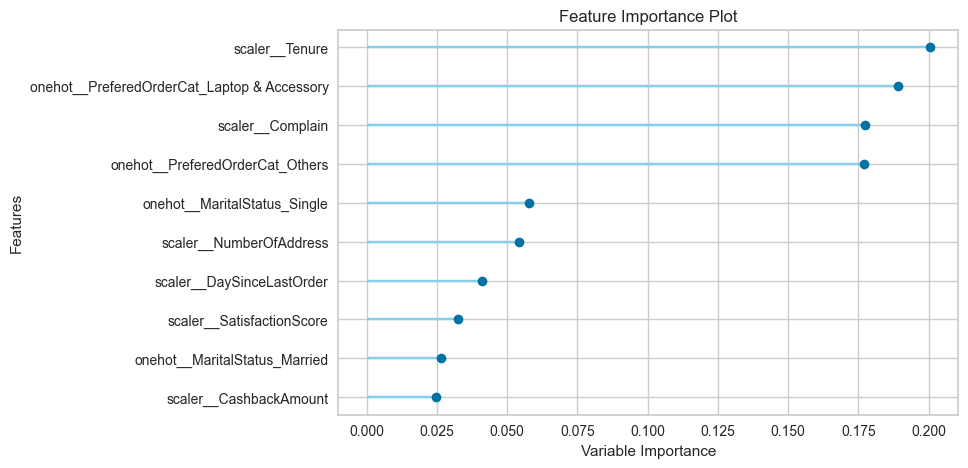

In [591]:
plot_model(xgb_model_final, plot='feature')

The scaled `Tenure` attribute has the most significant impact on the prediction results, followed by the the 'Laptop & Accessory' one-hot encoded dummy variable, the scaled `Complain` attribute, the 'Others' one-hot encoded dummy variable, and followed by the rest of the features.

## Predicting Test/Unseen Data

**Add metric for profit**

In [592]:
def calculate_profit(y, y_pred):
    tp = np.where((y_pred==1) & (y==1), (168-100), 0)
    fp = np.where((y_pred==1) & (y==0), -100, 0)
    return np.sum([tp,fp])

add_metric('profit', 'Profit', calculate_profit)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                   make_scorer(calculate_profit)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit, dtype: object

In [597]:
predict_unseen = predict_model(xgb_model_final, data=df_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUPRC,Profit
0,Extreme Gradient Boosting,0.9235,0.9405,0.7196,0.7938,0.7549,0.7097,0.7109,0.8069,3236


* **Accuracy**: The model achieved an overall accuracy of 92.35%, indicating a high proportion of correct predictions across both positive and negative classes.

* **AUC (Area Under the ROC Curve)**: With an AUC of 94.05%, the model exhibits strong discriminatory power, effectively distinguishing between positive and negative cases.

* **AUPRC (Area Under the Precision-Recall Curve)**: The AUPRC is 80.69%, reflecting the model's ability to maintain high precision across different recall levels, which is crucial in imbalanced datasets.

* **Recall (Sensitivity)**: The model correctly identified 71.96% of the actual positive cases, demonstrating its ability to capture a substantial portion of positive instances.

* **Precision (Positive Predictive Value)**: Precision is higher at 79.38%, indicating that when the model predicts a positive case, it is correct more than 79% of the time.

* **F1 Score**: The F1 score, at 75.49%, represents a balanced performance between precision and recall, offering a comprehensive evaluation of the model's effectiveness.

**Profit Evaluation**

* **Profit Calculation**: The profit is calculated by subtracting the cost of providing $100 vouchers from the average customer lifetime value of $168.

* **Strategy Outcome**: The positive profit indicates that the chosen strategy of offering vouchers to predicted churn customers is financially beneficial. The revenue gained from retaining customers surpasses the cost of providing vouchers, leading to a net profit.

* **Cost-Efficiency**: The profit of $3236 suggests that the strategy is cost-efficient, demonstrating that the business is gaining more in revenue from retained customers than it is spending on the voucher initiative.

* **Customer Retention Value**: The profit reflects the value derived from preventing customer churn. By incentivizing customers with vouchers, the business not only retains revenue from existing customers but also potentially increases future CLV.

Overall, the $3260 profit highlights the effectiveness of the churn prediction strategy in terms of both customer retention and financial gains.

## Conclusion

**Modelling Process**
* First, we compared the base models using standard preprocessing and we take 2 suitable ensemble and 2 standalone models which performs well to conduct tuning and resampling.
* After tuning and resampling experiments, we identified the tuned xgboost without resampling or penalizing as the best model.
* We then conduct feature selection using wrapper method to select significant variables.
* Finally, when predicting the test/unseen data, the final xgboost model performs significantly better.

**Model Limitation**
* The final XGBoost model exhibits a limitation in achieving a relatively low recall of 71.96% and an F1 score of 75.49%.
* One significant factor contributing to the limitation is the presence of imbalanced data in the target variable. While SMOTE does fix the imbalance, it may have introduced noises into the data.
* Another consideration is the potential lack of a sufficient amount of training data. Insufficient data may limit the model's ability to generalize patterns, impacting its overall performance.

**Business Impact**
* With the prediction model, e-commerce companies can retain customers and significantly reduce customer churn using tailored marketing strategy, such as the aforementioned $100 vouchers.
* Information obtained from churn prediction can be used to tailor other marketing strategies, such as using the feature importance plot, we can observe that the attribute `Complain` is a significant attribute. E-commerce businesses can focus on improving their customer service to reduce customer complaints.
* Overall, the prediction model will be able to help e-commerce businesses increase their profit.

## Recommendation

* To address the model limitations, further refinement of the model, exploration of advanced techniques for handling imbalanced data, increasing training or overall data, and different algorithms may be considered.
* It is also important to consider whether there are external factors not included in the model or changes in customer behavior.
* For business implementation, e-commerce businesses can use the model to predict churn and profit from retaining customers according to their respective estimated Customer Lifetime Value.

## Deployment

In [594]:
import pickle
pickle.dump(xgb_model_final, open('xgb_model_final.pkl', 'wb'))